<a href="https://colab.research.google.com/github/tylee33/Paper_Research/blob/main/gold_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pmdarima # install the missing package

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 3.6 MB/s eta 0:00:00


In [25]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math
import smtplib

from datetime import datetime
from email.message import EmailMessage
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import datetime
from numpy import log
import pmdarima as pmd
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import matplotlib
import warnings
import os
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
# Import data
df = pd.read_excel("/content/monthly_data.xlsx")

In [5]:
# Set index to date
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

In [6]:
# Fix the error with loading the plot
import matplotlib.pyplot as plt
from importlib import reload
plt=reload(plt)

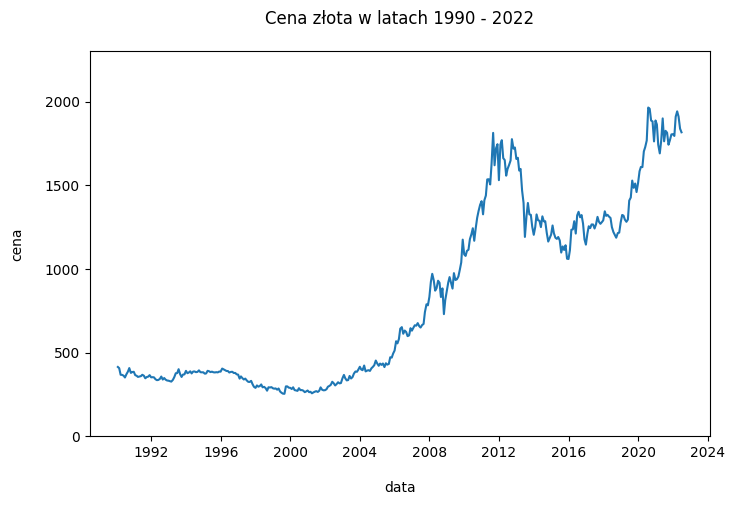

<Figure size 800x500 with 0 Axes>

In [7]:
# Visualize gold price
matplotlib.rcParams['figure.figsize'] = (8.0, 5.0)
plt.plot(df.Value)
plt.ylabel("cena", labelpad=15)
plt.xlabel("data", labelpad=15)
plt.title("Cena złota w latach 1990 - 2022", size=12, y=1.05)
plt.ylim([0, 2300])
fig1 = plt.gcf()
plt.show()
plt.draw()
# fig1.savefig('cena złota 1990 - 2022.png', dpi=100)

In [8]:
# Split data into out-of-sample and in-sample
train = df[:387]
test = df[387:390]

In [9]:
# Print basic statistics
mean = df.mean()
std = df.std()
lobs = df.count()
median = df.median()

print("liczba obserwacji:", lobs, "średnia:", mean, "odchylenie:", std, "mediana:",
      median, "min:", df.min(), "max:", df.max(), df.skew())

print("kurtoza:", df.kurtosis())

liczba obserwacji: Value    390
dtype: int64 średnia: Value    822.815513
dtype: float64 odchylenie: Value    533.028148
dtype: float64 mediana: Value    590.625
dtype: float64 min: Value    254.8
dtype: float64 max: Value    1964.9
dtype: float64 Value    0.542974
dtype: float64
kurtoza: Value   -1.191295
dtype: float64


In [10]:
# Describe in the form of table
df.describe(include='all')

,Value
count,390.000000
mean,822.815513
std,533.028148
min,254.800000
25%,357.525000
50%,590.625000
75%,1281.775000
max,1964.900000


In [11]:
# Differencing data
df_diff = train.diff()
df_diff.dropna(inplace=True)

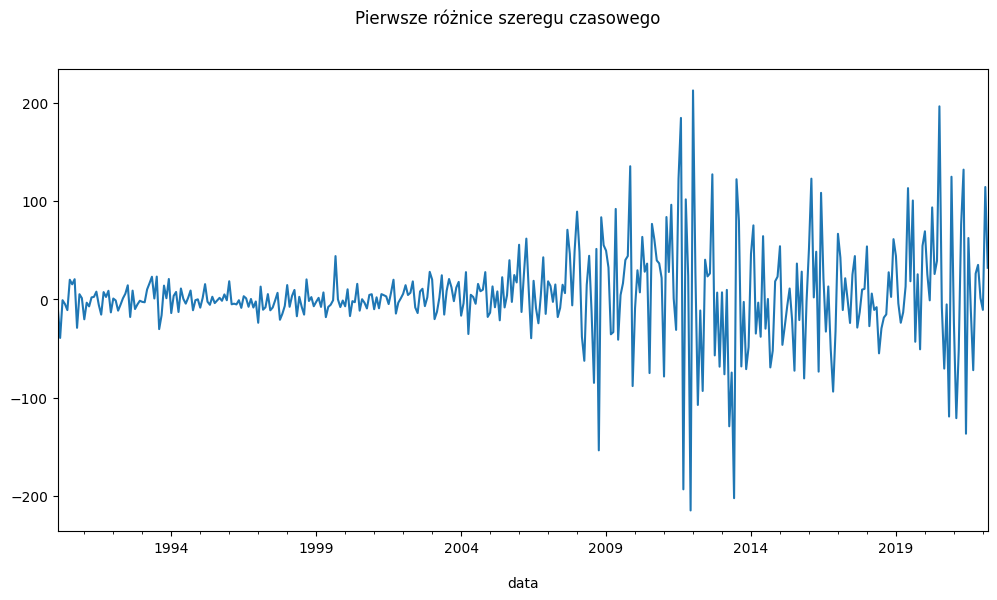

<Figure size 800x500 with 0 Axes>

In [12]:
# Plot diff data
fig, ax = plt.subplots(figsize=(12,6))
fig.suptitle('Pierwsze różnice szeregu czasowego')
df_diff['Value'].plot(ax=ax)
plt.xlabel("data", labelpad=15)
fig2 = plt.gcf()
plt.show()
plt.draw()
# fig2.savefig('pierwsze różnice.png', dpi=100)

In [13]:
# Testing stationarity

#ADF test for non-differenced data
result = adfuller(df['Value'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Test Statistics Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.181851
p-value: 0.940651
Critical Test Statistics Values:
	1%: -3.448
	5%: -2.869
	10%: -2.571


In [14]:
# ADF test for differenced data
result_diff = adfuller(df_diff['Value'])
print('ADF Statistic: %f' % result_diff[0])
print('p-value: %f' % result_diff[1])
print('Critical Test Statistics Values:')
for key, value in result_diff[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.879020
p-value: 0.000038
Critical Test Statistics Values:
	1%: -3.448
	5%: -2.869
	10%: -2.571


In [15]:
# KPSS test for non differenced data
def kpss_test(df, **kw):
    statistic, p_value, n_lags, critical_values = kpss(df.Value, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

kpss_test(df)

KPSS Statistic: 2.8419115305100138
p-value: 0.01
num lags: 11
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary


<ipython-input-15-2ee0746da359>:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  statistic, p_value, n_lags, critical_values = kpss(df.Value, **kw)


In [16]:
#KPSS test for differenced data
def kpss_test_diff(df_diff, **kw):
    statistic, p_value, n_lags, critical_values = kpss(df_diff.Value, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

kpss_test_diff(df_diff)

KPSS Statistic: 0.2865656000314476
p-value: 0.1
num lags: 2
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


<ipython-input-16-57bfb289c079>:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  statistic, p_value, n_lags, critical_values = kpss(df_diff.Value, **kw)


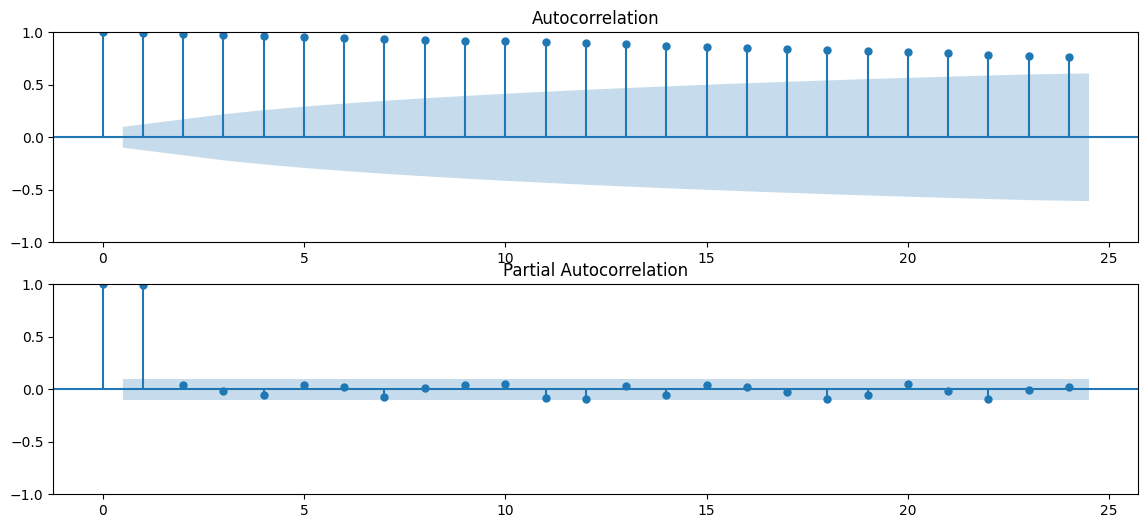

In [17]:
# ACF i PACF for non-differenced  data
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(14,6), sharex=False, sharey=False)
ax1 = plot_acf(df['Value'], lags=24, ax=ax1)
ax2 = plot_pacf(df['Value'], lags=24, ax=ax2)
plt.show()

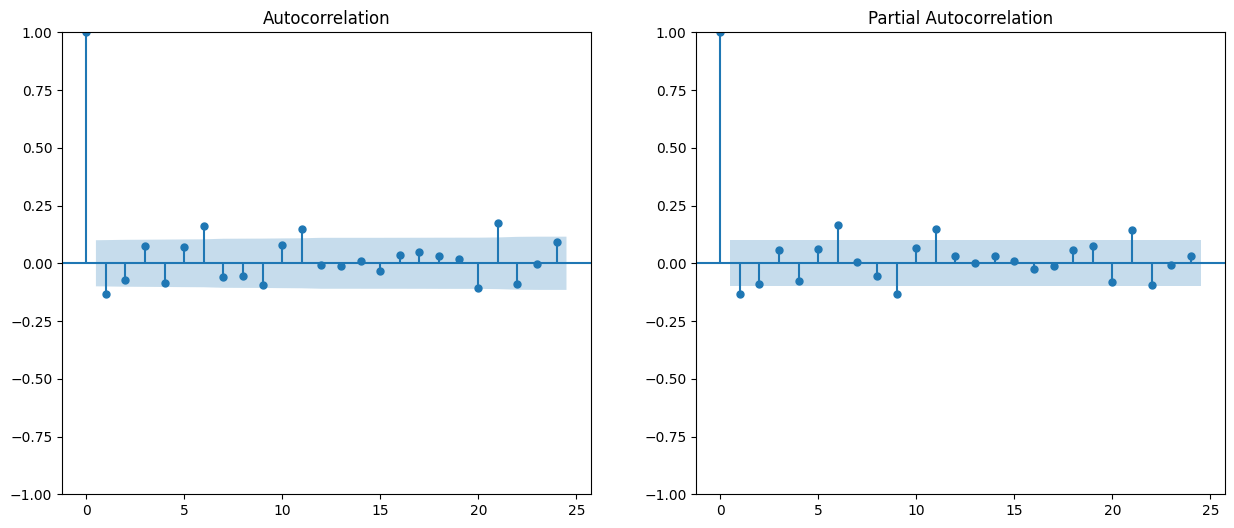

<Figure size 800x500 with 0 Axes>

In [18]:
# ACF i PACF dla diff data
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,6), sharex=False, sharey=False)
ax1 = plot_acf(df_diff['Value'], lags=24, ax=ax1)
ax2 = plot_pacf(df_diff['Value'], lags=24, ax=ax2)
fig3 = plt.gcf()
plt.show()
plt.draw()
# fig3.savefig('ACF and PACF')

In [19]:
# White noise test preparation
train = df[:387]
test = df[387:]
df_diff = train.diff()
df_diff.dropna(inplace=True)

In [20]:
# Box-Pierce test
acorr_ljungbox(df_diff['Value'], lags=[24], boxpierce=True, return_df=True)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
24,70.13457,0.000002,67.645164,0.000005


In [21]:
#Ljung Box test
acorr_ljungbox(df_diff['Value'], lags=[24], return_df=True)

,lb_stat,lb_pvalue
24,70.13457,0.000002


In [22]:
# ARIMA best model (autoarima)
def arimamodel(df):
    autoarima_model = pmd.auto_arima(train,
                                     start_p=1,
                                     start_q=1,
                                     test="adf",
                                     d=1,
                                     seasonal = False,
                                     error_action = 'ignore',
                                     suppress_warnings=True,
                                     trace=True)

arima_model = arimamodel(df['Value'])

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4077.946, Time=2.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4082.877, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4077.788, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4076.584, Time=0.89 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4083.525, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4077.335, Time=0.98 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4078.742, Time=0.87 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4078.302, Time=0.26 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 5.667 seconds


In [27]:
# Manually testing the best ARIMA model
# 1,1,1 ARIMA Model
model1 = ARIMA(train.Value, order=(1,1,1), freq="BM")
model_fit1 = model1.fit()
print(model_fit1.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency BM will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                  387
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2036.944
Date:                Fri, 27 Sep 2024   AIC                           4079.888
Time:                        06:42:03   BIC                           4091.756
Sample:                    01-31-1990   HQIC                          4084.594
                         - 03-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1581      0.235      0.673      0.501      -0.302       0.619
ma.L1         -0.2979      0.226     -1.320      0.187      -0.740       0.144
sigma2      2244.3862     90.433     24.818      0.0

In [29]:
# 1,1,0 ARIMA Model
model2 = ARIMA(train.Value, order=(1,1,0), freq="BM")
model_fit2 = model2.fit()
print(model_fit2.summary())

                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                  387
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -2037.612
Date:                Fri, 27 Sep 2024   AIC                           4079.224
Time:                        06:42:31   BIC                           4087.136
Sample:                    01-31-1990   HQIC                          4082.362
                         - 03-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1271      0.028     -4.477      0.000      -0.183      -0.071
sigma2      2257.8843     89.622     25.194      0.000    2082.229    2433.539
Ljung-Box (L1) (Q):                   0.15   Jarque-

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency BM will be used.
  self._init_dates(dates, freq)
